In [1]:
# import packages

import matplotlib.animation as animation
import time
import importlib
import sys
import pickle
import pandas as pd
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import norm
from scipy import stats
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
plt.rcParams.update({'font.size': 34})
%matplotlib inline
import sys
import scipy
import os
from importlib import reload

PATH_DATA = '../data/' 
PATH = '../codes/'
sys.path.insert(1,PATH)

vcol =['rosybrown','red','darkseagreen','orange','blueviolet','lawngreen','fuchsia','cyan','darkolivegreen','black','deepskyblue','lightslategray','darkslateblue','sienna','darkgoldenrod','olive']

import IAE_CNN_TORCH_Oct2023 as cnn
from model_selection_variability import BCD,model_selection,POMP,_get_barycenter
import model_selection_variability

from general import normalize,normalize4, divergence, NNPU, NMF_divergence,index_array_3D,list_array



C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Read data

In [2]:

def read_spectrum(fname):
    spec = []
    for line in open(fname, 'r'):
        spec.append(float(line.rstrip()))
    return np.array(spec)


def GetListData(name=0):
    PATH_DATA=os.path.join('../data/Simulation_steel_sphere', RN_NAME[name])
    list_thickness=[]
    list_data=[]

    for file in os.listdir(PATH_DATA):
        if file.endswith(".dat"):
            tmp_file=os.path.join(PATH_DATA, file)
            list_data+=[tmp_file]
    ## list thickness
    ## replace __ = . , (2__0=2.0mm)
    for tmp_file in list_data:
        pos=tmp_file.find("STEEL")
        tmp_thick=tmp_file.replace(tmp_file[:pos+5],"")
        tmp=tmp_thick.replace("mm.dat","")
        if "__" in tmp:
            tmp=tmp.replace("__",".")
        list_thickness+=[float(tmp)]
    ##sort data 
    ind=np.argsort(list_thickness)
    list_thickness=np.sort(list_thickness)
    list_data = [list_data[i] for i in ind]

    return list_data,list_thickness


def GetSpectra(name=0):
    list_data,list_thickness=GetListData(name)
    spec=[]
    for i in range(len(list_data)):
        spec += [read_spectrum(list_data[i])]
    spec=np.array(spec).T
    # cut 20kev 
    # 1024 channels, 1 channel=2kev
    spec = spec[20:2048+20,:]
    spec=spec[0::2,:]+spec[1::2,:]
    ## channel>max channel: value =0
    spec[max_channel_list[name]:,:]=0
    ## Am241 with high thicknesses, spectral signatures are almost absored by attenuation 
    ## X of Am241 for thickness >4 mm = X of 4 mm  
    if name==5:
        spec[:,30:]=spec[:,29:30].dot(np.ones((1,spec.shape[1]-30)))
    
    return spec.T,list_thickness

## Load pre-trained IAE models

In [3]:
PATH="Images"# Folder Images
name_fig_sup='_exp1' # additional figure name


In [4]:
# joint model
fname='./Models/IAE_CNN_12radio_40data'
model=cnn.load_model(fname)
model.nneg_output=True

## Define spectral signature X using thickness

In [5]:
# Initiazation matrix X from thickness
def init_X(XMVP,position):
    # position: position of thickness used to create X
    Xtmp=spec_list[position].squeeze()
    Xtmp=(np.concatenate([XMVP,Xtmp],axis=1))
    return Xtmp

## MVP  (Natural Background (Bkg))

In [6]:
MVP=read_spectrum('../data/SPS_NaITl_3pouces_Exp_1keVCanal_Max2200keV_#20012023A.txt')
MVP=MVP[20:2048+20]
MVP=MVP[0::2]+MVP[1::2]
MVP=MVP[:]
## avoid zeros for Bkg
MVP[:2]=1/10*min(MVP[2:])
XMVP=MVP/np.sum(MVP)
XMVP=XMVP[:,np.newaxis]

# Create a gamma-simulation

In [7]:
RN_NAME=['Co60', 'Ba133', 'Co57','Cs137','Eu152','Am241','Y88','Bi207','I123','I131','Tc99m','Ga67']
max_channel_list=np.array([800,250,100,400,900,50,1024,800,100,500,100,250]) # max energy for each radionuclide
norm='1'# normalizing norm
spec_list=[]
for name in range((len(RN_NAME))):
    spec,list_thickness=GetSpectra(name)
    spec_list+=[spec]
spec_list=np.swapaxes(spec_list,0,1)
spec_list=np.swapaxes(spec_list,1,2)
spec_list=normalize4(spec_list[:,:,:],opt=norm)

In [8]:
position_exact=70# thickness
counting=2500 # total counting
coef=np.array([0.5,0.15,0 ,0 ,0.1,0 ,0 , 0.15,0,0,0,0.1,0]) # mixing weights
#coef=np.array([0.5,0,0.3 ,0 ,0.2,0 ,0 , 0,0,0,0,0,0])

########################
X=init_X(XMVP,position_exact)    
X0=init_X(XMVP,0) # init thickness: 0.001 mm
radio=coef>0
nbr_step=len(coef[radio])
name_label=['Bkg']+ RN_NAME
list_radio=np.arange(len(name_label))[radio]
list_radio2=np.arange(len(coef)-1)[coef[1:]>0]

print('Thickness: ',list_thickness[position_exact])
print('Radio: ',['Bkg']+RN_NAME)
print('Expected counting: ',counting*coef)

print(list_radio)
print(np.array(name_label)[radio])

Thickness:  20.1
Radio:  ['Bkg', 'Co60', 'Ba133', 'Co57', 'Cs137', 'Eu152', 'Am241', 'Y88', 'Bi207', 'I123', 'I131', 'Tc99m', 'Ga67']
Expected counting:  [1250.  375.    0.    0.  250.    0.    0.  375.    0.    0.    0.  250.
    0.]
[ 0  1  4  7 11]
['Bkg' 'Co60' 'Cs137' 'Y88' 'Tc99m']


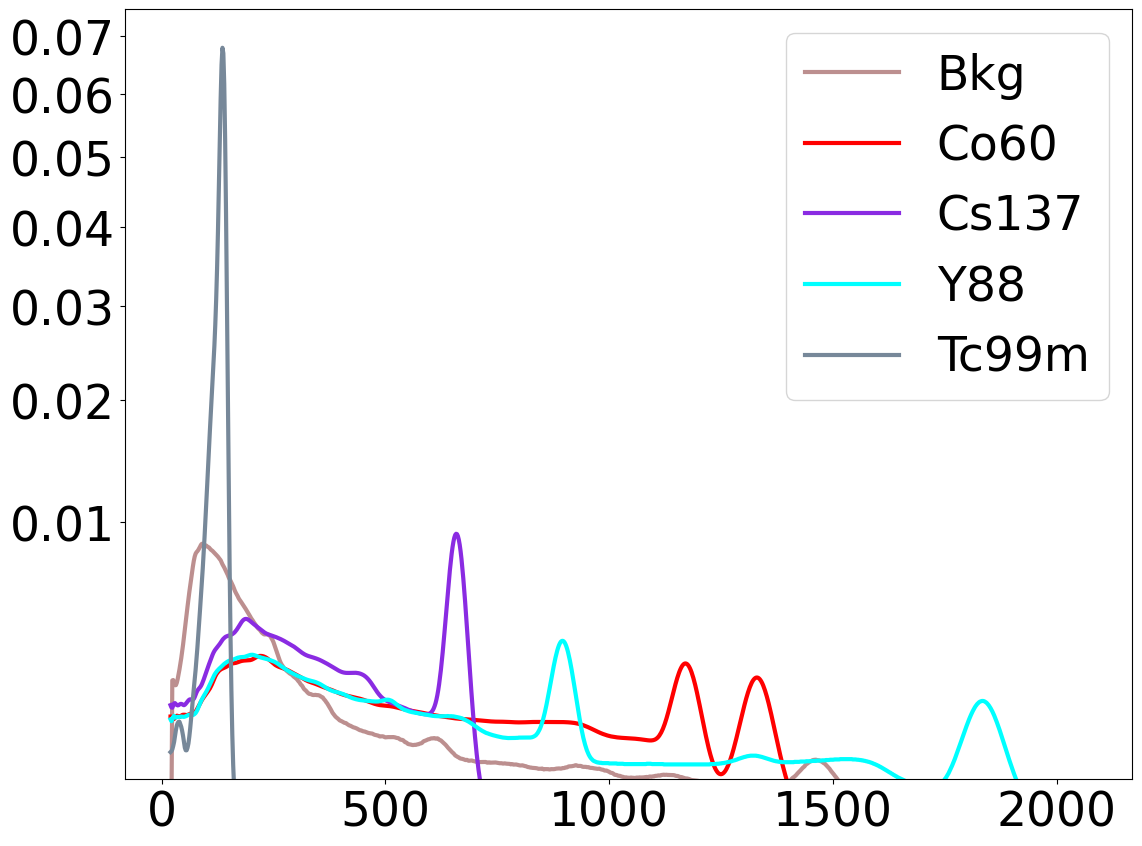

In [9]:
color_list=vcol
name_label=['Bkg']+ RN_NAME
plt.figure(figsize=(13,10))
enr=(np.arange(1024)*2+20) 
list_radio_plot=list(list_radio)
for i in range(len(list_radio_plot)):
    plt.plot(enr,X[:,list_radio_plot[i]],label=name_label[list_radio_plot[i]],lw=3,color=color_list[list_radio_plot[i]])
plt.legend()
f = lambda a: a**(1/2)
g = lambda a: a**2
plt.yscale('function', functions=(f,g))

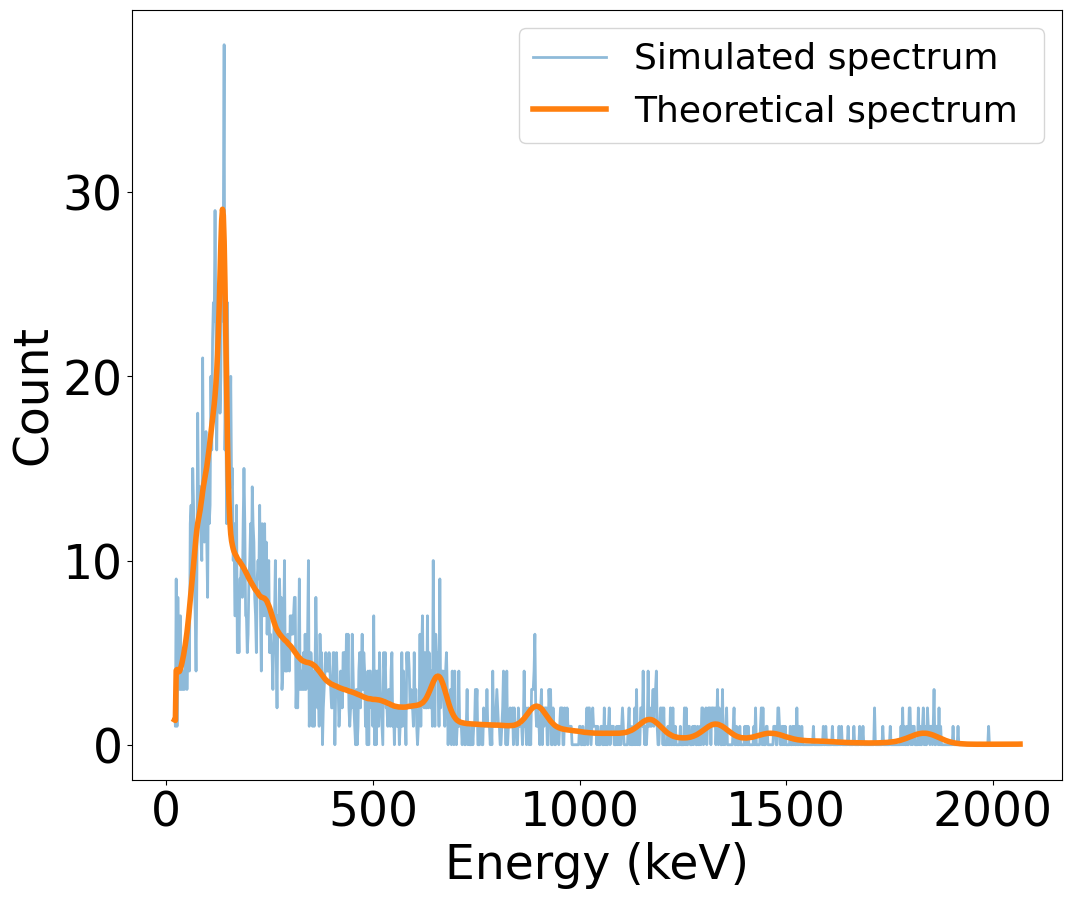

In [10]:
M,N=np.shape(X)
a=counting*coef
lamb=X.dot(a) # Poisson parameter
np.random.seed(0)
y=np.random.poisson(lamb) 
a0=np.sum(lamb)/len(a)*np.ones((len(a))) # initial value of a
enr=(np.arange(1024)*2+20)/100*100    
plt.figure(figsize=(12,10))
plt.plot(enr,y,lw=2,alpha=0.5,label='Simulated spectrum')
plt.plot(enr,lamb,lw=4,label='Theoretical spectrum ')
plt.xlabel('Energy (keV)')
plt.ylabel('Count')
plt.legend(fontsize=26)

# P-OMP: known spectral singatures

In [11]:
t1=time.time()
res_pomp=POMP(y,X,1/100,turn=2)
print('Expected: ',a)
print('Estimated counting:',res_pomp['a'])
print('Identified radionuclides: ',res_pomp['Iden'])
print('Estimated Standard diviation: ',res_pomp['Std'])
print('Selection procedure: ',res_pomp['Procedure']) # switch to a mixture of Ba133 and Cs137 to see the difference
print('time: ',time.time()-t1)


Expected:  [1250.  375.    0.    0.  250.    0.    0.  375.    0.    0.    0.  250.
    0.]
Estimated counting: [1225.07715611  404.08411692    0.            0.          308.87724119
    0.            0.          380.63970167    0.            0.
    0.          229.32178412    0.        ]
Identified radionuclides:  [0, 7, 1, 11, 4]
Estimated Standard diviation:  [74.33456197 52.5081413   0.          0.         45.96181858  0.
  0.         53.64082573  0.          0.          0.         27.56216889
  0.        ]
Selection procedure:  [0, 7, 1, 11, 4]
time:  3.1505160331726074


# MoSeVa: spectral unmixing with spectral variability

In [12]:
importlib.reload(model_selection_variability)
from model_selection_variability import BCD,model_selection,POMP,_get_barycenter

In [13]:
t1=time.time()
alpha=1/100 # expected false positive rate
# X is optional,can be None, just to calculate NMSE of estimated X
#a0_i =0 inital counting of radionuclide i =0 -> tested dictionary doesnot contain this radionuclide
res_moseva=model_selection(y,X0,a0,X=None,list_model=[model],estimed_aMVP=1,tol_BSP=1e-8,
        tol=1e-4,niter_max_out=30,niter_max_BSP=100,step_size_BSP=1e-4,optim=0,turn=2,alpha=alpha)
print('time: ',time.time()-t1)

[0, 7]
[0, 7, 1]
[0, 7, 1, 11]
[0, 7, 1, 11, 4]
time:  98.54827237129211


In [14]:
print('Expected: ',a)
print('Identified radionuclides: ',res_moseva['Iden'])
print('Estimated counting: ',res_moseva['Quan'][1])
print('Estimated std: ',res_moseva['Std'][:-1])
print('Estimated lambda: ',res_moseva['LambdaList'][-1])
#print('Selection procedure: ',res_moseva['Procedure'])

Expected:  [1250.  375.    0.    0.  250.    0.    0.  375.    0.    0.    0.  250.
    0.]
Identified radionuclides:  [0, 7, 1, 11, 4]
Estimated counting:  [1222.43957349  407.71120167    0.            0.          309.03527541
    0.            0.          379.20829858    0.            0.
    0.          229.60565084    0.        ]
Estimated std:  [88. 54.  0.  0. 46.  0.  0. 55.  0.  0.  0. 28.  0.]
Estimated lambda:  [0.11934377 0.88065623]


### Estimated spectral signatures

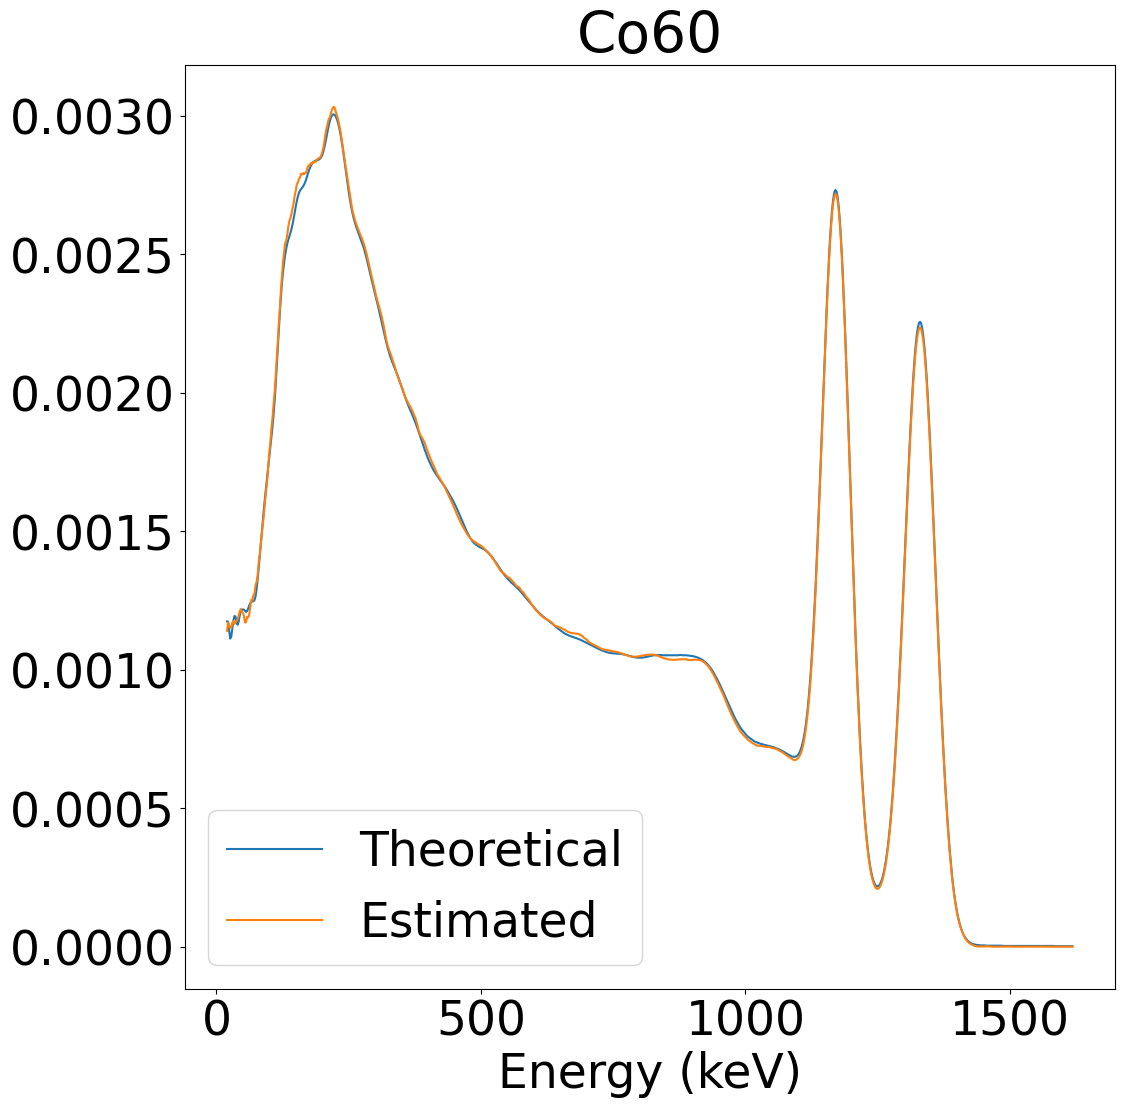

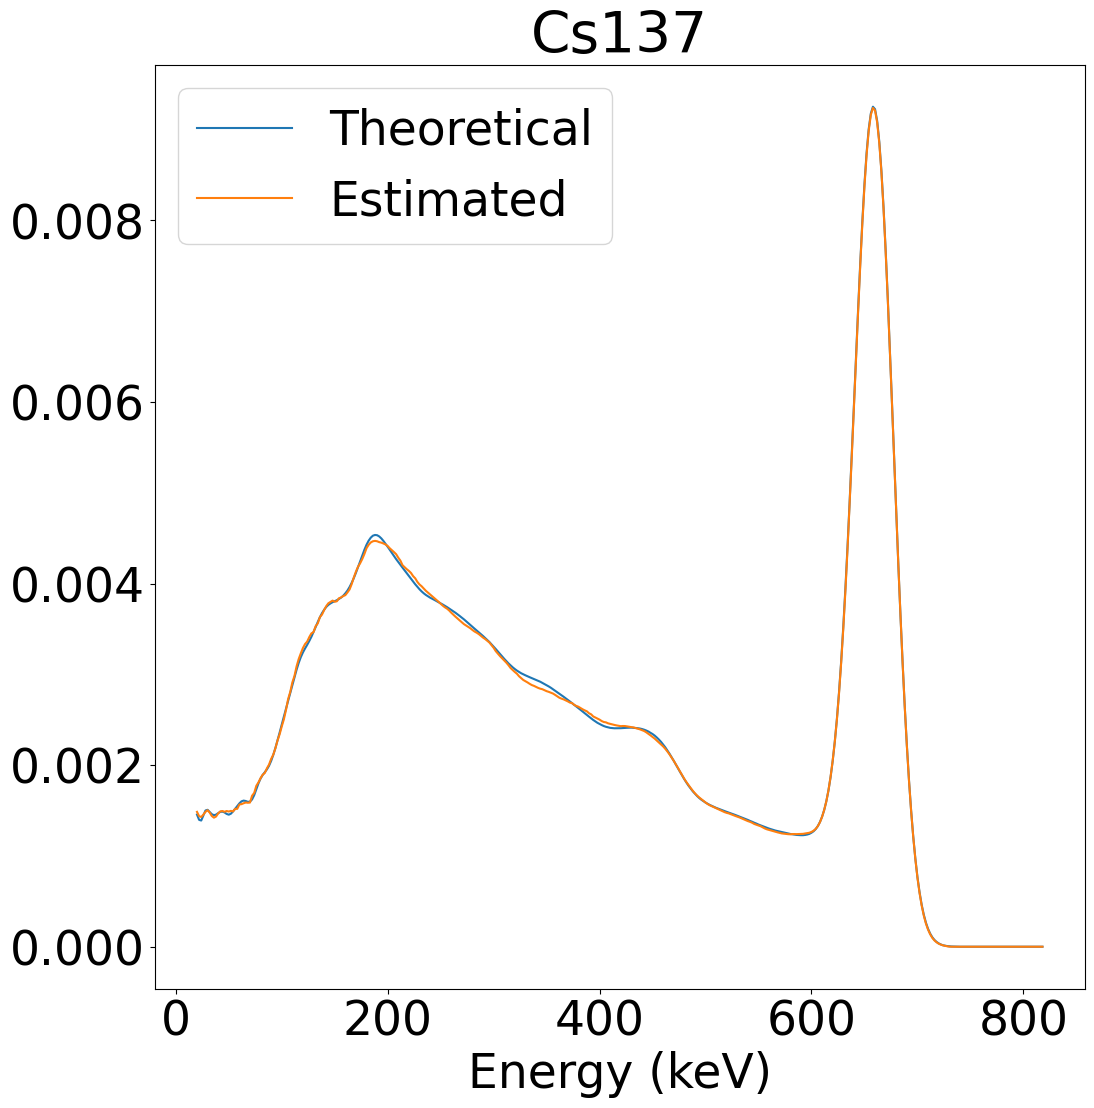

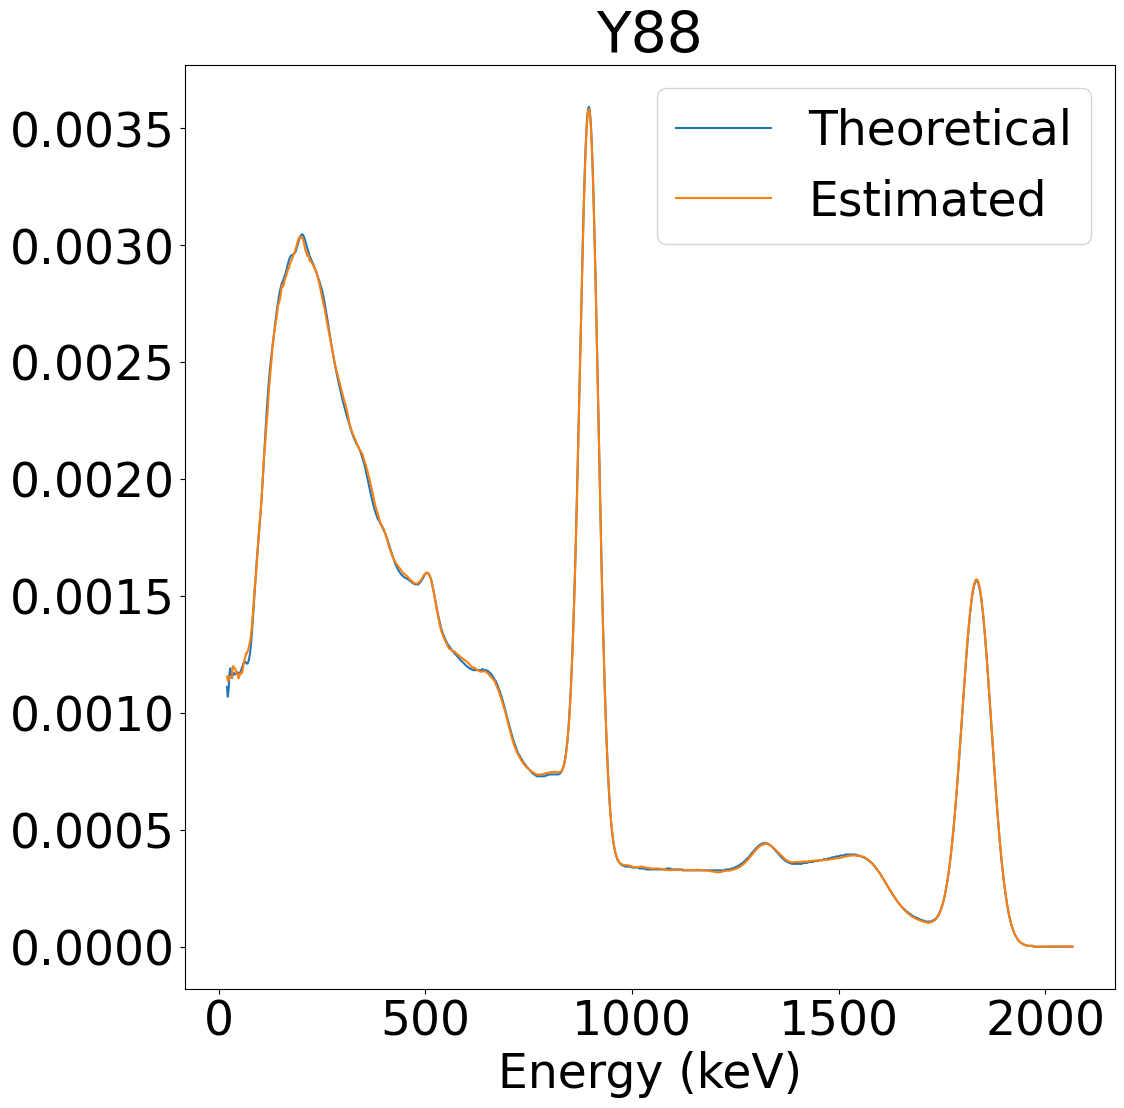

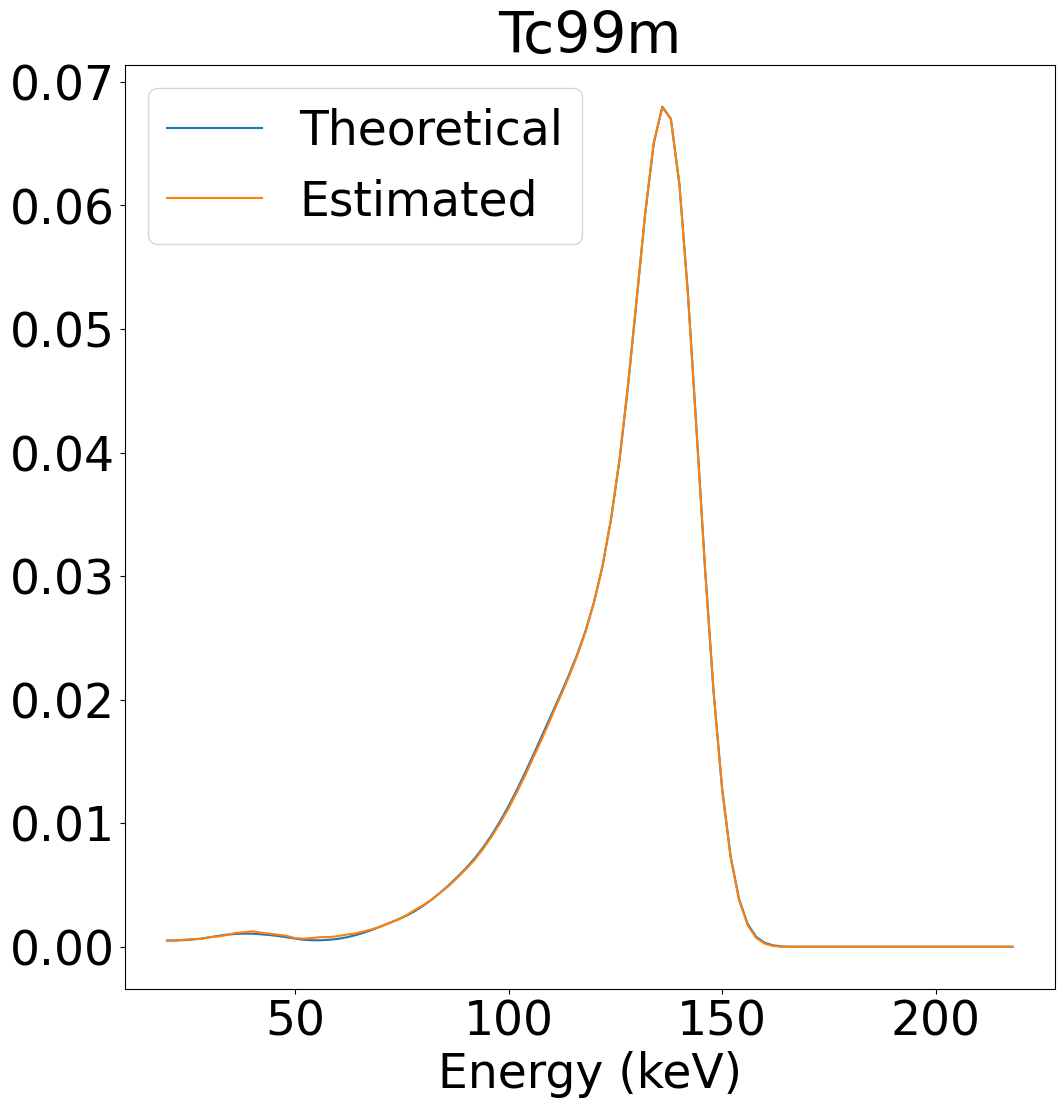

In [15]:
for i in range(len(list_radio2)):
    plt.figure(figsize=(12,12))
    max_channel=max_channel_list[list_radio2[i]]
    enr=np.arange(max_channel)*2+20   
    plt.plot(enr,X[:max_channel,list_radio2[i]+1],label='Theoretical')
    plt.plot(enr,res_moseva['Quan'][0][:max_channel,list_radio2[i]+1],label='Estimated')
    plt.xlabel('Energy (keV)')
    plt.title(RN_NAME[list_radio2[i]])
    plt.legend()
    plt.show()

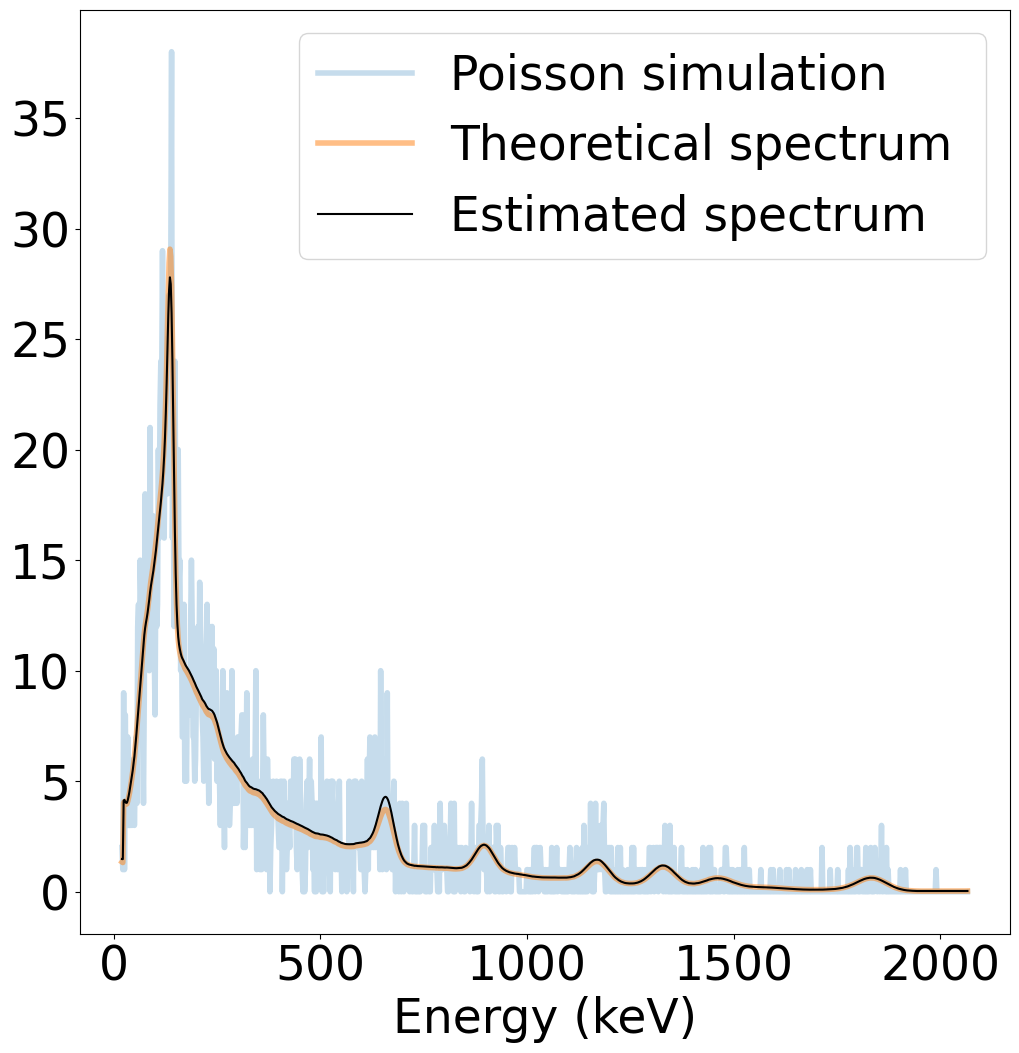

In [16]:
plt.figure(figsize=(12,12))
enr=np.arange(1024)*2+20 
plt.plot(enr,y,label='Poisson simulation',lw=4,alpha=0.25)
plt.plot(enr,lamb,label='Theoretical spectrum ',lw=4,alpha=0.5)
plt.plot(enr,res_moseva['Quan'][0].dot(res_moseva['Quan'][1]),'k',label='Estimated spectrum')
plt.xlabel('Energy (keV)')
plt.legend()
plt.show()